In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import numpy as np
import torch
from torch.nn import Sequential, ReLU, Linear, Conv1d, LSTM, RNN, Dropout
from torch.nn import Module
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor   
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

from NCP.model import DeepSVD
from NCP.layers import SingularLayer, MLPOperator

np.random.seed(0)
torch.manual_seed(0)
Ntrain = 10000
Nval = 10000
Ntest = 10000

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Heteroscedastic

We study the ability of our method to learn conditional distributions using the following toy example:
$ Y \sim \mathcal{N}(X^2, 1+\vert X \vert)$

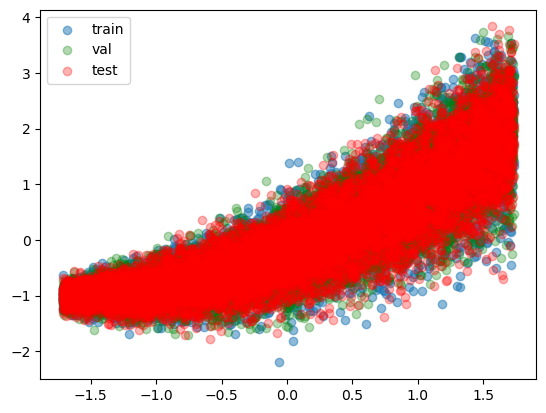

In [13]:
X = np.random.uniform(0, 5, Ntrain+Nval+Ntest)
Y = np.zeros(X.shape[0])
for i, xi in enumerate(X):
    Y[i] = xi**2 + np.random.normal(0, 1+xi)

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()
# Xtransformed = X - X.mean()
# Ytransformed = Y - Y.mean()

Xtransformed = xscaler.fit_transform(X)
Ytransformed = yscaler.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(Xtransformed, Ytransformed, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

We train our model using two MLP for $U_\theta$ and $V_\theta$.

epoch = 9999, loss = -1.6323413848876953: 100%|██████████| 10000/10000 [00:39<00:00, 251.17it/s]


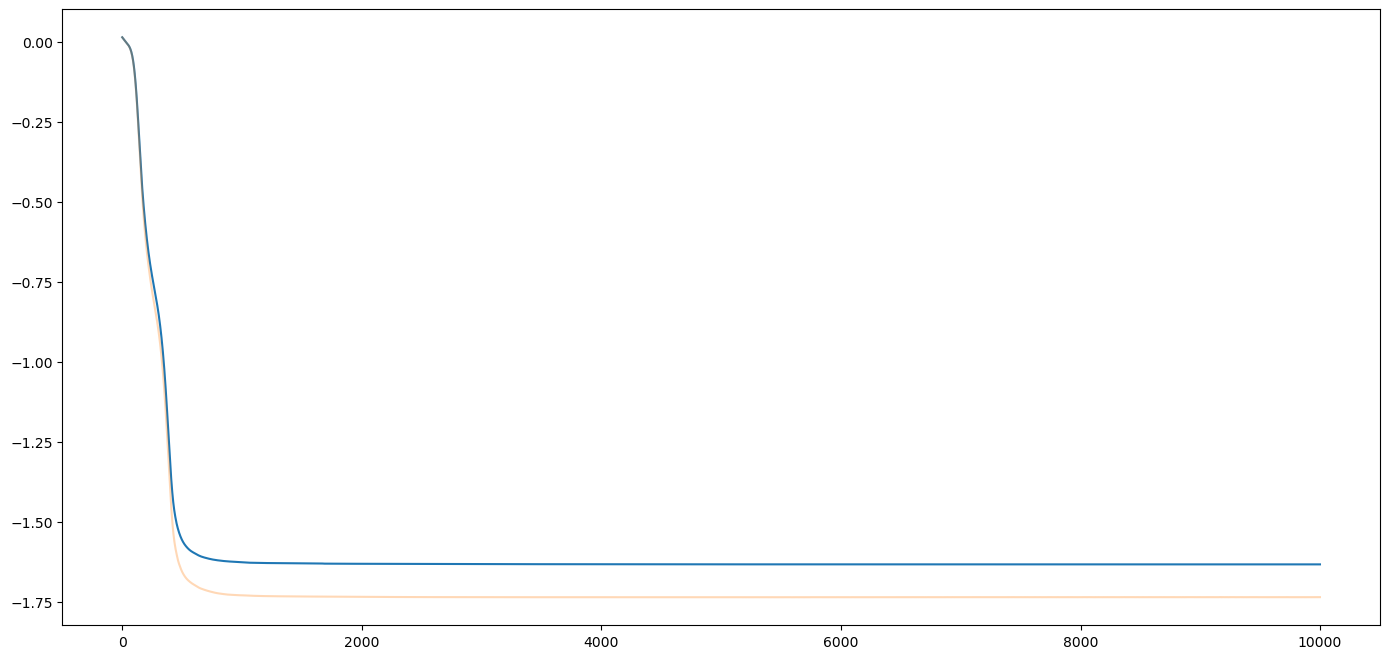

In [14]:
np.random.seed(0)
torch.manual_seed(0)

input_shape = X_train.shape[-1]
output_shape = 2
n_hidden = 2
layer_size = 4 # layer size of hidden layers.

U_operator = MLPOperator(input_shape, n_hidden, layer_size, output_shape)
V_operator = MLPOperator(input_shape, n_hidden, layer_size, output_shape)

optimizer = Adam
optimizer_kwargs = {
    'lr': 1e-3
    }
reg = (DeepSVD(U_operator, V_operator, output_shape, gamma=0.))

reg.fit(X_train, Y_train, X_val, Y_val, epochs=int(1e4), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)

ls = reg.get_losses()
plt.figure(figsize=(17, 8))
plt.plot(range(len(ls)), np.array(ls))
plt.plot(range(len(ls)), np.array(reg.get_val_losses()), alpha=0.3)
# plt.yscale('log')
plt.show()

As we can see, the loss converges. Let us first verify that we are able to predict the expectation of the model:

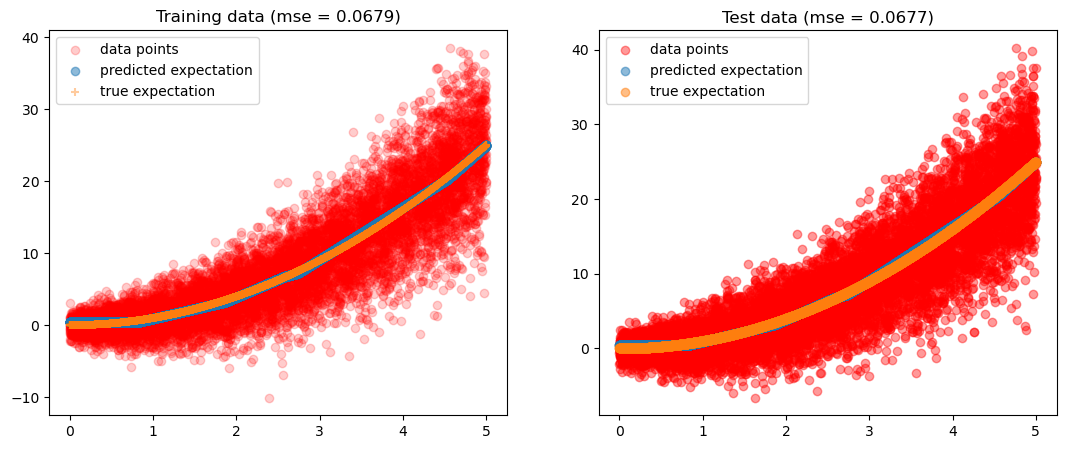

In [33]:
pred = reg.predict_expectation(X_train).reshape(-1, 1)
pred_test = reg.predict_expectation(X_test).reshape(-1, 1)

fig, axs = plt.subplots(ncols=2, figsize=(13, 5))
axes = axs.flatten()

Xs = xscaler.inverse_transform(X_train)
axes[0].scatter(Xs, 
                yscaler.inverse_transform(Y_train), 
                color='r', alpha=0.2)
axes[0].scatter(Xs, 
             yscaler.inverse_transform(pred), 
             alpha=0.5)
axes[0].scatter(Xs, Xs**2, marker='+', alpha=0.4)
axes[0].legend(['data points', 'predicted expectation', 'true expectation'])
axes[0].set_title(f'Training data (mse = {round(mean_squared_error(Xs**2, yscaler.inverse_transform(pred)), 4)})')

Xs = xscaler.inverse_transform(X_test)
axes[1].scatter(Xs, 
                yscaler.inverse_transform(Y_test), 
                color='r', alpha=0.4)
axes[1].scatter(Xs, 
             yscaler.inverse_transform(pred_test), 
             alpha=0.5)
axes[1].scatter(Xs, Xs**2, alpha=0.5)
axes[1].legend(['data points', 'predicted expectation', 'true expectation'])
axes[1].set_title(f'Test data (mse = {round(mean_squared_error(Xs**2, yscaler.inverse_transform(pred_test)), 4)})')

plt.show()

Let us now examine the CDF for varying values of X:

In [7]:
# distances for one dimensional distributions

# all measures take empirical cdfs computed for the same values as input

def hellinger(x,y):
    x_hist = np.diff(x, prepend=0)
    y_hist = np.diff(y, prepend=0) 
    return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)

def kullback_leibler(x,y):
    x_hist = np.diff(x, prepend=0)
    y_hist =np.diff(y, prepend=0) 
    return np.sum(x_hist*np.log(y_hist/x_hist))

def wasserstein1(x,y):
    return np.linalg.norm((x**-1)-(y**-1), ord=1)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x12000 and 10000x2)

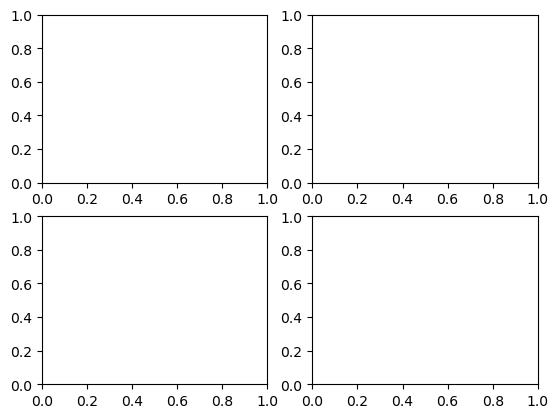

In [10]:
from scipy.stats import norm
from NCP.cdf import get_cdf

fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3, 7]):

    x_scaled = torch.Tensor(xscaler.transform(X))
    fys, cdf_pred = get_cdf(reg, x_scaled)
    cdf_unscaled = yscaler.inverse_transform(cdf_pred)

    true_cdf = norm.cdf(fys, loc=X**1, scale=1+np.abs(X))

    axes[i].plot(fys, cdf_unscaled)
    axes[i].plot(fys, true_cdf)
    axes[i].text('KL: ', kullback_leibler(cdf_unscaled, true_cdf), horizontalalignement='left')
    axes[i].text('Hellinger: ', hellinger(cdf_unscaled, true_cdf), horizontalalignement='left')
    axes[i].text('Wasserstein: ', wasserstein1(cdf_unscaled, true_cdf), horizontalalignement='left')

plt.show()